# Proyek Klasifikasi Gambar: [Rice Classification ]
- **Nama:** [Wahyu Ozorah Manurung]
- **Email:** [wahyuozorahmanurung@gmail.com]
- **ID Dicoding:** [MC189D5Y0409]



## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from google.colab import files
from PIL import Image
import skimage
from collections import defaultdict
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import TFSMLayer

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wahyuozorah","key":"0c6005ea804811ebebb96cdb61ab3cb9"}'}

Saya meng upload token kaggle saya

In [4]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [5]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset
!unzip rice-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

In [6]:
def count_image_by_class(dataset_path):
  class_counts ={}
  for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
      class_counts[class_name] = len(os.listdir(class_folder))

  print("\nJumlah gambar per kelas: ")
  for class_name, count in class_counts.items():
    print(f"- {class_name}: {count} gambar")

  return class_counts

In [10]:
def count_image_by_resolution(dataset_path):
   resolution_counts = defaultdict(int)

   for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                try:
                    with Image.open(image_path) as img:
                        resolution = img.size
                        resolution_counts[resolution] += 1
                except:
                    print(f" Gagal membaca {image_path}")

   print("\nJumlah gambar berdasarkan resolusi:")
   for resolution, count in resolution_counts.items():
        print(f"- {resolution}: {count} gambar")

   return resolution_counts

In [51]:

dataset_path = "Rice_Image_Dataset"

count_image_by_class(dataset_path)
count_image_by_resolution(dataset_path)

Streaming output truncated to the last 5000 lines.
- (246, 264): 11 gambar
- (203, 202): 8 gambar
- (276, 241): 4 gambar
- (207, 203): 5 gambar
- (286, 241): 6 gambar
- (217, 288): 5 gambar
- (297, 236): 8 gambar
- (263, 265): 10 gambar
- (219, 209): 5 gambar
- (211, 203): 10 gambar
- (224, 261): 8 gambar
- (236, 281): 19 gambar
- (288, 241): 9 gambar
- (292, 269): 6 gambar
- (241, 289): 5 gambar
- (252, 227): 6 gambar
- (209, 280): 7 gambar
- (290, 201): 5 gambar
- (207, 281): 4 gambar
- (224, 264): 8 gambar
- (252, 218): 6 gambar
- (214, 266): 8 gambar
- (288, 224): 9 gambar
- (228, 250): 13 gambar
- (286, 298): 9 gambar
- (290, 232): 12 gambar
- (267, 299): 3 gambar
- (218, 289): 10 gambar
- (226, 299): 8 gambar
- (283, 272): 6 gambar
- (273, 277): 6 gambar
- (262, 287): 9 gambar
- (267, 226): 8 gambar
- (243, 216): 10 gambar
- (300, 224): 7 gambar
- (270, 254): 5 gambar
- (268, 286): 5 gambar
- (300, 288): 4 gambar
- (215, 260): 7 gambar
- (245, 203): 11 gambar
- (217, 222): 7 gamb

defaultdict(int,
            {(258, 295): 10,
             (266, 213): 5,
             (273, 276): 6,
             (214, 226): 5,
             (257, 278): 5,
             (298, 264): 7,
             (230, 227): 5,
             (221, 251): 10,
             (275, 300): 9,
             (238, 217): 11,
             (294, 212): 8,
             (278, 273): 10,
             (244, 239): 10,
             (212, 284): 13,
             (251, 239): 9,
             (274, 280): 7,
             (208, 284): 9,
             (280, 217): 11,
             (244, 273): 12,
             (228, 235): 9,
             (260, 277): 5,
             (300, 211): 8,
             (244, 237): 12,
             (269, 218): 7,
             (229, 218): 11,
             (225, 237): 8,
             (290, 267): 10,
             (212, 216): 6,
             (237, 289): 10,
             (238, 214): 7,
             (222, 243): 7,
             (252, 259): 12,
             (285, 208): 5,
             (216, 262): 6,
             (271,

Kode ini digunakan untuk menganalisis dataset gambar dengan dua cara. Pertama, fungsi count_image_by_class(dataset_path) menghitung jumlah gambar yang ada di setiap kelas dalam dataset, di mana dataset disusun dalam subfolder berdasarkan kelas gambar (misalnya, subfolder "rice" untuk gambar padi). Fungsi kedua, count_image_by_resolution(dataset_path), menghitung jumlah gambar berdasarkan resolusinya, dengan membuka setiap gambar dan mengidentifikasi ukurannya.

In [16]:
def resize_img(dataset_path, min_resolution=200, max_resolution=300):
  for root, dirs, folder in os.walk(dataset_path):
    for file in folder:
      file_path = os.path.join(root,file)

      if file.lower().endswith((".jpg")):
        with Image.open(file_path) as img:
          new_width = random.randint(min_resolution, max_resolution)
          new_height = random.randint(min_resolution, max_resolution)

          resized_images = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

          resized_images.save(file_path)

dataset_path = "/content/Rice_Image_Dataset"

resize_img(dataset_path)

In [17]:
dataset_path = "Rice_Image_Dataset"

count_image_by_class(dataset_path)
count_image_by_resolution(dataset_path)

Streaming output truncated to the last 5000 lines.
- (246, 264): 11 gambar
- (203, 202): 8 gambar
- (276, 241): 4 gambar
- (207, 203): 5 gambar
- (286, 241): 6 gambar
- (217, 288): 5 gambar
- (297, 236): 8 gambar
- (263, 265): 10 gambar
- (219, 209): 5 gambar
- (211, 203): 10 gambar
- (224, 261): 8 gambar
- (236, 281): 19 gambar
- (288, 241): 9 gambar
- (292, 269): 6 gambar
- (241, 289): 5 gambar
- (252, 227): 6 gambar
- (209, 280): 7 gambar
- (290, 201): 5 gambar
- (207, 281): 4 gambar
- (224, 264): 8 gambar
- (252, 218): 6 gambar
- (214, 266): 8 gambar
- (288, 224): 9 gambar
- (228, 250): 13 gambar
- (286, 298): 9 gambar
- (290, 232): 12 gambar
- (267, 299): 3 gambar
- (218, 289): 10 gambar
- (226, 299): 8 gambar
- (283, 272): 6 gambar
- (273, 277): 6 gambar
- (262, 287): 9 gambar
- (267, 226): 8 gambar
- (243, 216): 10 gambar
- (300, 224): 7 gambar
- (270, 254): 5 gambar
- (268, 286): 5 gambar
- (300, 288): 4 gambar
- (215, 260): 7 gambar
- (245, 203): 11 gambar
- (217, 222): 7 gamb

defaultdict(int,
            {(258, 295): 10,
             (266, 213): 5,
             (273, 276): 6,
             (214, 226): 5,
             (257, 278): 5,
             (298, 264): 7,
             (230, 227): 5,
             (221, 251): 10,
             (275, 300): 9,
             (238, 217): 11,
             (294, 212): 8,
             (278, 273): 10,
             (244, 239): 10,
             (212, 284): 13,
             (251, 239): 9,
             (274, 280): 7,
             (208, 284): 9,
             (280, 217): 11,
             (244, 273): 12,
             (228, 235): 9,
             (260, 277): 5,
             (300, 211): 8,
             (244, 237): 12,
             (269, 218): 7,
             (229, 218): 11,
             (225, 237): 8,
             (290, 267): 10,
             (212, 216): 6,
             (237, 289): 10,
             (238, 214): 7,
             (222, 243): 7,
             (252, 259): 12,
             (285, 208): 5,
             (216, 262): 6,
             (271,

In [18]:
def counts_image(dataset_path):
    total_count = 0
    image_exts = ('.jpg')

    for root, dirs, files in os.walk(dataset_path):
        image_files = [f for f in files if f.lower().endswith(image_exts)]
        total_count += len(image_files)

    return total_count

dataset_path = "Rice_Image_Dataset"
total_count = counts_image(dataset_path)

print(f"Jumlah total gambar jenis beras dalam dataset: {total_count}")

Jumlah total gambar jenis beras dalam dataset: 75000


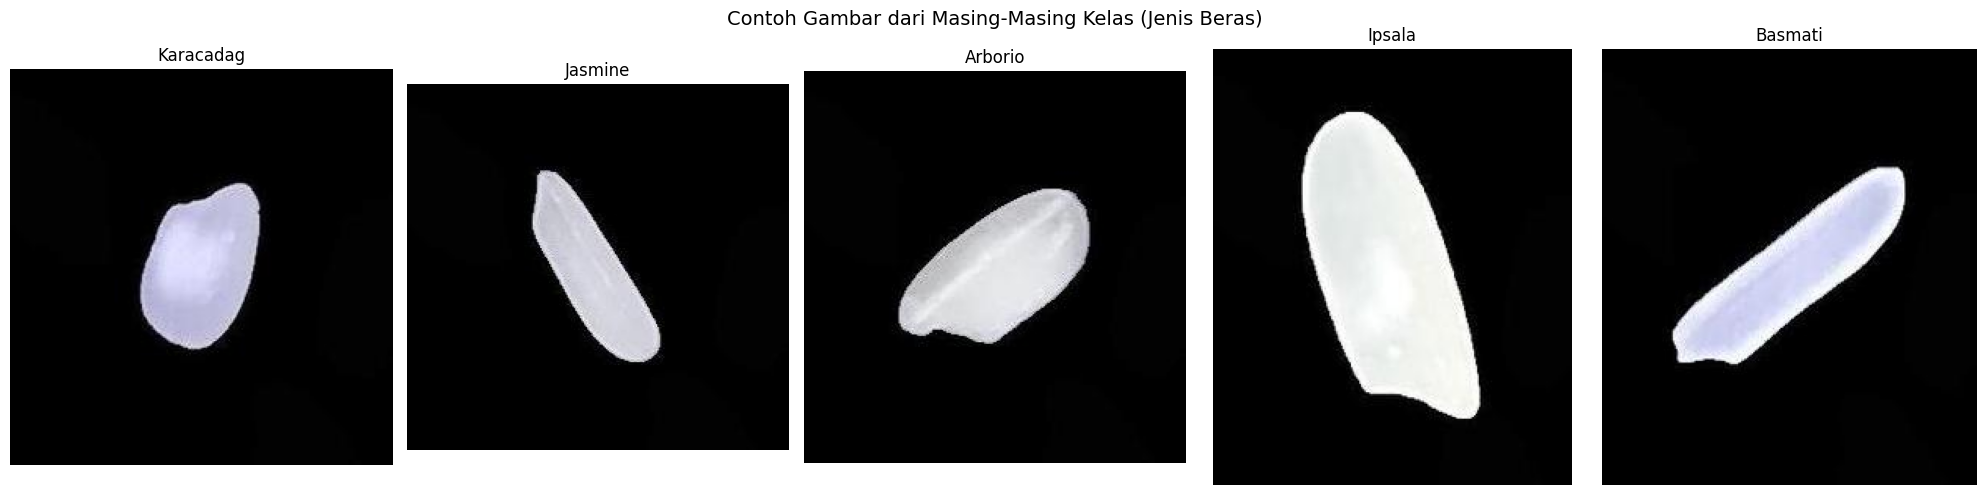

In [19]:
def show_example_image(dataset_path):
    class_images = {}

    # Ambil satu gambar acak dari setiap kelas
    for root, dirs, files in os.walk(dataset_path):
        if files:
            class_name = os.path.basename(root)
            image_files = [f for f in files if f.lower().endswith(('.jpg'))]
            if image_files:
                random_image = random.choice(image_files)
                class_images[class_name] = os.path.join(root, random_image)

    fig, axes = plt.subplots(1, len(class_images), figsize=(4 * len(class_images), 5))
    fig.suptitle('Contoh Gambar dari Masing-Masing Kelas (Jenis Beras)', fontsize=14)

    if len(class_images) == 1:
        axes = [axes]

    for ax, (class_name, image_path) in zip(axes, class_images.items()):
        img = Image.open(image_path)
        ax.imshow(img)
        ax.set_title(class_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


dataset_path = "Rice_Image_Dataset"

show_example_image(dataset_path)



Jumlah gambar per kelas: 
- Karacadag: 15000 gambar
- Jasmine: 15000 gambar
- Arborio: 15000 gambar
- Ipsala: 15000 gambar
- Basmati: 15000 gambar


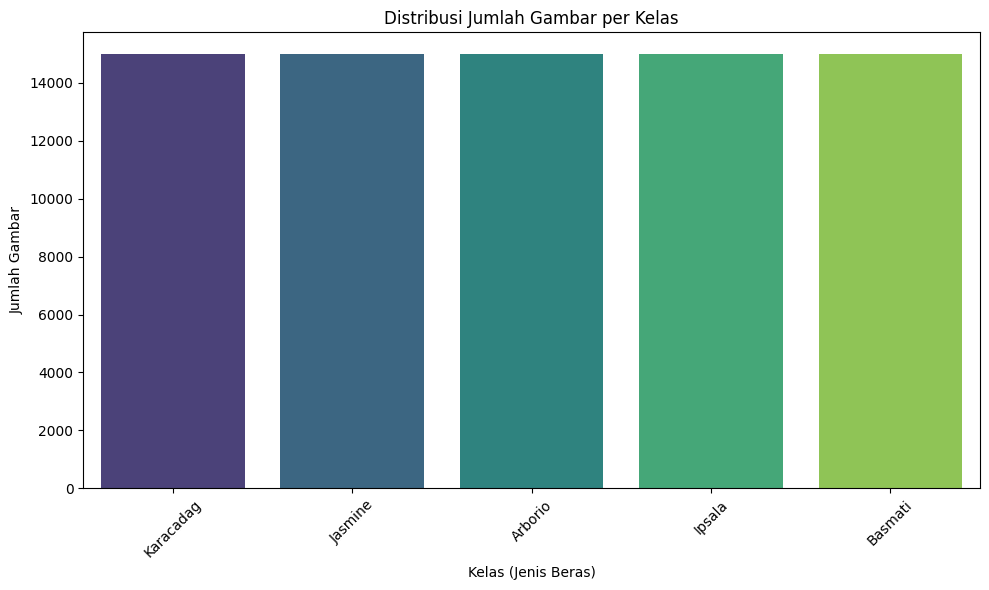

In [23]:
def plot_class_distribution(class_counts):
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10,6))
    sns.barplot(x=class_names, y=counts, palette='viridis')
    plt.title("Distribusi Jumlah Gambar per Kelas")
    plt.xlabel("Kelas (Jenis Beras)")
    plt.ylabel("Jumlah Gambar")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

dataset_path = "Rice_Image_Dataset"
class_counts = count_image_by_class(dataset_path)
plot_class_distribution(class_counts)


In [20]:
def calculate_blur(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    return cv2.Laplacian(img, cv2.CV_64F).var()

def average_blur(dataset_path):
    blur_values = []
    failed_images = 0

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith('.jpg'):
                image_path = os.path.join(root, file)
                blur = calculate_blur(image_path)
                if blur is not None:
                    blur_values.append(blur)
                else:
                    failed_images += 1

    avg_blur = np.mean(blur_values)
    print(f"Rata-rata Kejelasan (Blur) pada Dataset: {avg_blur:.2f}")
    if failed_images > 0:
        print(f"Gagal menghitung blur pada {failed_images} gambar.")
    return avg_blur, blur_values


In [21]:
dataset_path = "Rice_Image_Dataset"
avg_blur, blur_values = average_blur(dataset_path)


Rata-rata Kejelasan (Blur) pada Dataset: 379.19


Rata-rata Kejelasan (Blur): 379.19 ➜ Jauh di atas 100 Artinya: Mayoritas gambar tajam & tidak buram. Tidak perlu hapus gambar karena blur.

### Data Preprocessing

**Selanjutnya tahapan preprosesing saya lakukan pada split data set**

#### Split Dataset

In [24]:
def split_dataset(dataset_path, output_path, train_ratio=0.7, val_ratio=0.1):

    # membuat folder utama untuk dataset hasil split
    os.makedirs(output_path, exist_ok=True)

    #mmembuat folder train, val, test di dalam output_path
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(output_path, split), exist_ok=True)

    # Ambil semua kategori (hanya folder, bukan file)
    categories = [cat for cat in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cat))]

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        print(f"Memproses kategori: {category}")

        # membuatfolder kategori di dalam train, val, test
        for split in ["train", "val", "test"]:
            os.makedirs(os.path.join(output_path, split, category), exist_ok=True)

        # mengambil semua file gambar dan acak urutannya
        images = [f for f in os.listdir(category_path) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
        random.shuffle(images)

        # menghitung jumlah gambar untuk setiap subset
        train_count = int(len(images) * train_ratio)
        val_count = int(len(images) * val_ratio)

        # Bagi gambar ke dalam masing-masing set
        splits = {
            "train": images[:train_count],
            "val": images[train_count:train_count + val_count],
            "test": images[train_count + val_count:]
        }

        # Salin gambar ke folder baru (tidak menimpa dataset asli)
        for split, image_list in splits.items():
            for img in image_list:
                src = os.path.join(category_path, img)
                dst = os.path.join(output_path, split, category, img)
                shutil.copy2(src, dst)  # Copy file tanpa menghapus aslinya

    print("Split dataset selesai.")


dataset_path = "Rice_Image_Dataset"
output_path = "Rice_Image_Dataset_Split"

split_dataset(dataset_path, output_path)

Memproses kategori: Karacadag
Memproses kategori: Jasmine
Memproses kategori: Arborio
Memproses kategori: Ipsala
Memproses kategori: Basmati
Split dataset selesai.


**Melakukan image generator**

In [25]:
def preprocessing_dt(train_dir, val_dir, test_dir, target_size=(150,150), batch_size=32):
  train_data = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      horizontal_flip=True,
      zoom_range=0.2,
      fill_mode='nearest'
  )

  #resclae validation & test
  test_val_data = ImageDataGenerator(rescale=1./255)

  # Generator untuk masing-masing subset
  train_generator = train_data.flow_from_directory(
      train_dir,
      target_size=target_size,
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True
  )
  val_generator = test_val_data.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

  test_generator = test_val_data.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

  return train_generator, val_generator, test_generator

**SPLITT DATA SET**

Membagi menjadi data train, test dan validasi

In [26]:
train_dir='/content/Rice_Image_Dataset_Split/train'
val_dir='/content/Rice_Image_Dataset_Split/val'
test_dir= '/content/Rice_Image_Dataset_Split/test'

train_gen, val_gen, test_gen = preprocessing_dt(train_dir, val_dir, test_dir)

Found 52500 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


## Modelling

In [28]:

# Inisialisasi pretrained model MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Membekukan bobot pretrained model
for layer in base_model.layers:
    layer.trainable = False

# Membangun model secara berurutan
model = Sequential()

# Menambahkan backbone pretrained
model.add(base_model)

# Layer tambahan Conv2D dan Pooling
model.add(Conv2D(48, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Menyusun layer akhir klasifikasi
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))  # 5 output class

# Kompilasi model
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Menampilkan arsitektur model
model.summary()

<ipython-input-28-d450b6830716>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 48)       │       553,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 2, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,865,621 (10.93 MB)

 Trainable params: 607,637 (2.32 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

**CALLBACK**

In [30]:
# ModelCheckpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# EarlyStopping
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    mode='min'
)

# Custom callback untuk menghentikan training saat akurasi mencapai 98%
class AccuracyThresholdCallback(Callback):
    def __init__(self, threshold=0.98):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        if acc is not None and acc >= self.threshold:
            print(f"\nAkurasi mencapai {acc:.2%}, menghentikan training.")
            self.model.stop_training = True

accuracy_threshold = AccuracyThresholdCallback(threshold=0.98)

In [31]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint, earlystop, accuracy_threshold],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 322s 189ms/step - accuracy: 0.8929 - loss: 0.2930 - val_accuracy: 0.9784 - val_loss: 0.0631
Epoch 2/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 295s 180ms/step - accuracy: 0.9719 - loss: 0.0819 - val_accuracy: 0.9740 - val_loss: 0.0703
Epoch 3/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 295s 180ms/step - accuracy: 0.9760 - loss: 0.0718 - val_accuracy: 0.9759 - val_loss: 0.0660
Epoch 4/20
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9789 - loss: 0.0636
Akurasi mencapai 98.01%, menghentikan training.
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 295s 180ms/step - accuracy: 0.9789 - loss: 0.0636 - val_accuracy: 0.9523 - val_loss: 0.1468


## Evaluasi dan Visualisasi

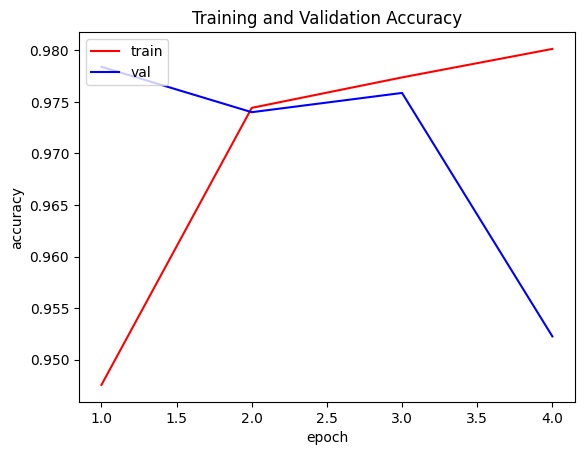

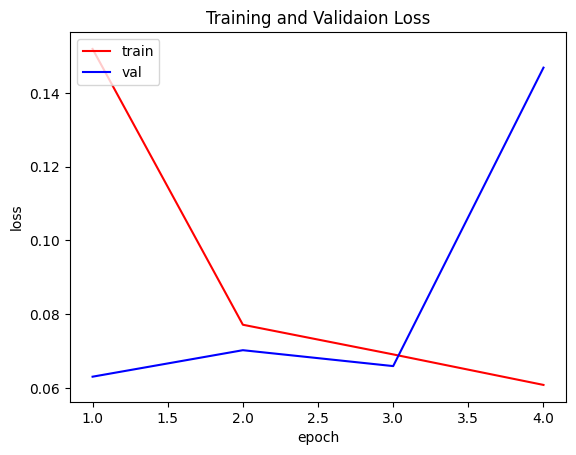

In [33]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training and Validaion Loss')
    plt.show()


plot_training_history(history)


In [34]:
# Cek akurasi
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_loss, test_acc = model.evaluate(test_gen, verbose=1)

print(f"Training Accuracy: {train_acc:.2%}")
print(f"Validation Accuracy: {val_acc:.2%}")
print(f"Test Accuracy: {test_acc:.2%}")

  1/469 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 1.0000 - loss: 0.0058

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9851 - loss: 0.0432
Training Accuracy: 98.01%
Validation Accuracy: 95.23%
Test Accuracy: 98.31%


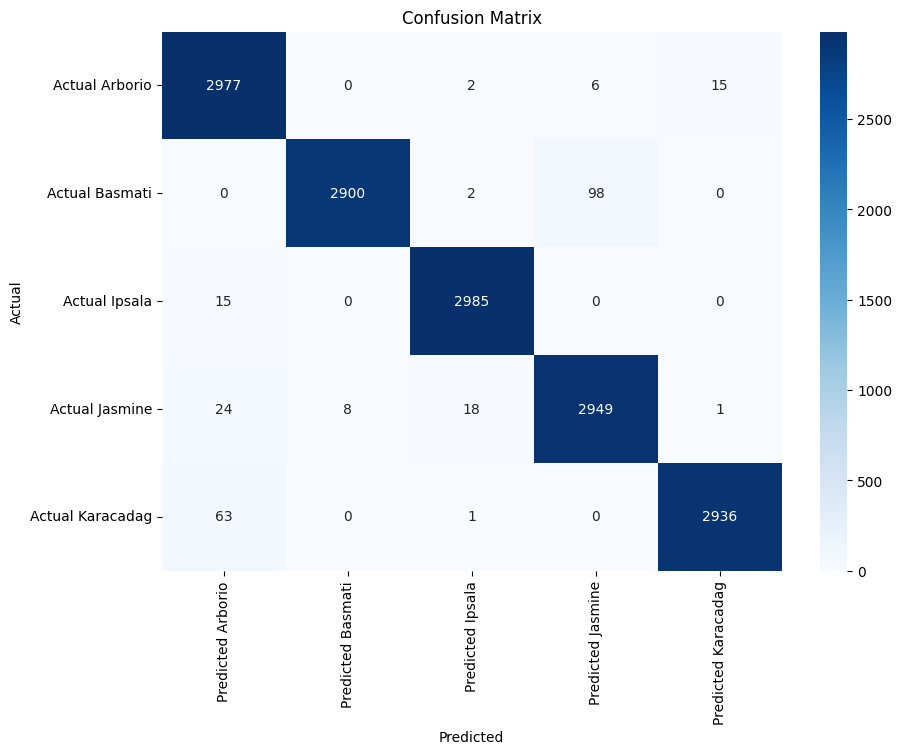


Classification Report:
              precision    recall  f1-score   support

     Arborio     0.9669    0.9923    0.9794      3000
     Basmati     0.9972    0.9667    0.9817      3000
      Ipsala     0.9924    0.9950    0.9937      3000
     Jasmine     0.9659    0.9830    0.9744      3000
   Karacadag     0.9946    0.9787    0.9866      3000

    accuracy                         0.9831     15000
   macro avg     0.9834    0.9831    0.9832     15000
weighted avg     0.9834    0.9831    0.9832     15000



In [35]:
# Reset generator
test_gen.reset()

# Prediksi model
preds = model.predict(test_gen, verbose=0)

# Konversi prediksi one-hot ke label indeks
y_pred = np.argmax(preds, axis=1)

# Ambil label ground truth dari generator
y_true = test_gen.classes

# Label mapping (opsional, ganti sesuai kelasmu)
class_labels = list(test_gen.class_indices.keys())  # ['class1', 'class2', ..., 'class5']

# Confusion Matrix
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred),
    index=[f"Actual {label}" for label in class_labels],
    columns=[f"Predicted {label}" for label in class_labels]
)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))


Hasil Classification Report menunjukkan kinerja model dalam mengklasifikasikan gambar beras ke dalam lima kelas: Arborio, Basmati, Ipsala, Jasmine, dan Karacadag. Metrik yang digunakan mencakup precision, recall, dan f1-score.

Precision yang tinggi menunjukkan bahwa model jarang salah mengklasifikasikan gambar ke kelas yang salah. Misalnya, pada kelas Basmati, precision mencapai 0.9972, yang berarti hampir 99.72% gambar yang diprediksi sebagai Basmati benar-benar Basmati.

Recall mengukur seberapa banyak gambar dari kelas yang sebenarnya berhasil dikenali oleh model. Pada kelas Ipsala, recall mencapai 0.9950, menunjukkan model sangat baik dalam mengenali gambar Ipsala.

F1-score adalah rata-rata harmonik antara precision dan recall, yang memberi gambaran lebih seimbang tentang performa model. F1-score untuk kelas Karacadag adalah 0.9866, menunjukkan kinerja yang solid dan seimbang.

Model secara keseluruhan memiliki accuracy sebesar 98.31%, yang berarti model berhasil mengklasifikasikan gambar dengan benar hampir 98.31% dari total 15.000 gambar. Rata-rata metrik macro avg dan weighted avg yang tercatat hampir identik, dengan nilai sekitar 0.9834 untuk precision, 0.9831 untuk recall, dan 0.9832 untuk f1-score, menunjukkan kinerja model yang sangat seimbang dan andal di semua kelas. Secara keseluruhan, model ini menunjukkan kemampuan yang luar biasa dalam klasifikasi gambar, dengan kesalahan yang sangat minim.

## Konversi Model

In [37]:
# 1. Simpan model dalam format SavedModel
saved_model_dir = "saved_model_rice"
tf.saved_model.save(model, saved_model_dir)
print(f" Model disimpan dalam format SavedModel di: {saved_model_dir}")

# 2. Konversi ke TensorFlow Lite (TFLite)
tflite_model_path = "rice_model.tflite"

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"Model berhasil dikonversi ke format TFLite dan disimpan di: {tflite_model_path}")

# 3. Konversi ke TensorFlow.js (TFJS)
!pip install tensorflowjs  # pastikan sudah terinstal

tfjs_target_dir = "tfjs_model_rice"

# Konversi SavedModel ke TFJS
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model \
  --signature_name=serving_default --saved_model_tags=serve \
  {saved_model_dir} {tfjs_target_dir}

print(f" Model berhasil dikonversi ke TensorFlow.js dan disimpan di folder: {tfjs_target_dir}")

 Model disimpan dalam format SavedModel di: saved_model_rice
Model berhasil dikonversi ke format TFLite dan disimpan di: rice_model.tflite
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-12 11:18:12.432329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744456692.456049   19014 cuda_dnn.cc:8

## Inference (Optional)

In [47]:


# Load model dari SavedModel
model_layer = TFSMLayer('saved_model_rice', call_endpoint='serving_default')

# Daftar gambar untuk diuji
img_paths = [
    '/content/Rice_Image_Dataset/Arborio/Arborio (1).jpg'
]

# Daftar nama kelas
class_names = ['Arborio', 'Basmati', 'Jasmine', 'Ipsala', 'Karacadag']

# Loop untuk memproses setiap gambar
for img_path in img_paths:
    print(f"Memproses gambar: {img_path}")

    # Load dan preprocess gambar
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Inference
    output = model_layer(img_array)
    output_tensor = output['output_0']

    # Menampilkan probabilitas untuk setiap kelas
    print("Probabilitas untuk setiap kelas:")
    for i, class_prob in enumerate(output_tensor[0]):
        print(f"{class_names[i]}: {class_prob.numpy():.4f}")

    # Menampilkan kelas yang diprediksi
    predicted_class = tf.argmax(output_tensor, axis=-1).numpy()
    print(f"Kelas yang diprediksi: {class_names[predicted_class[0]]}\n")


Memproses gambar: /content/Rice_Image_Dataset/Arborio/Arborio (1).jpg
Probabilitas untuk setiap kelas:
Arborio: 1.0000
Basmati: 0.0000
Jasmine: 0.0000
Ipsala: 0.0000
Karacadag: 0.0000
Kelas yang diprediksi: Arborio

